<a href="https://colab.research.google.com/github/sid1336/Computational-Physics-Projects/blob/main/Gravitational_waves_detection_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Utkarsh Sachdeva (sid)
- York university
- 219964444
- Astrophyics and Computer science

# <font color=#46769B>Black Holes and Gravitational Waves</font>


This project is divided into four sections:

- __Section I:__ We are tasked with applying your knowledge of spectral analysis to real LIGO data from the first gravitational wave event ever recorded from merging black holes. We will extract the mass of the black holes by analyzing the LIGO signal.

- __Section II:__ Using the Runge-Kutta method (RK4) for solving ODEs, We will solve for the inspiraling motion of two black holes.

- __Section III:__ By fitting a model for the gravitational waveform to the LIGO data, We will again determine the chirp mass by performing a Markov Chain Monte Carlo simulation.




## <font color=#46769B>Introduction</font>

In 2015, the Laser Interferometer Gravitational-Wave Observatory (LIGO) made history by making the [first direct observation of gravitational waves](https://www.ligo.org/detections/GW150914.php) (see also [here](https://en.wikipedia.org/wiki/First_observation_of_gravitational_waves)).
These gravitational waves were the product of a binary pair of black holes (BHs), each around 30 solar masses, orbiting around each other and inspiralling as they lose energy, until they finally met their end in a cataclysmic merger.

More information about gravitational waves can be found [here](https://www.ligo.caltech.edu/page/gravitational-waves). If you would like to learn more about the remarkable LIGO experiment, you can watch a video [here](https://www.youtube.com/watch?v=iphcyNWFD10).

In a nutshell, LIGO is an ultra-precise ruler that measures how a separation distance $L$ changes as a passing gravitational wave stretches and squashes space. The basic idea is illustrated by the following animations:

<table><tr>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/b/b8/GravitationalWave_PlusPolarization.gif" width="150"> </td>
<td> <img src="https://upload.wikimedia.org/wikipedia/commons/b/b8/GravitationalWave_CrossPolarization.gif" width="150">
</tr></table>

The distance between objects (solid points) alternately increases and decreases by the ripple in spacetime caused by the gravitational wave. The time period of squashing and stretching is simply (half) the orbital period of the binary BH pair that are emitting gravitational waves as they orbit one another. However, it is not a simple *uniform* periodic signal. Since the BHs are losing energy by emitting gravitational waves, they are *inspiraling*, orbiting faster and faster as they get closer and closer, until finally there is a violent merger (resulting in a single BH). Therefore, the signal is a [chirp](https://en.wikipedia.org/wiki/Chirp), characterized by a frequency that is rising in time.

Now, we will load the LIGO data. We will look at a 32 s window around the first detected gravitational wave event: __GW150914__ (which stands for __G__ravitational __W__ave event detected on yy/mm/dd = __15/09/14__.)
There are two LIGO datasets, one for each of the LIGO detectors: Hanford, WA, USA and Livingston, LA, USA. Since gravitational waves are expected to pass over the entire Earth, both detectors should see an event at the same time, modulo a small difference due to travel time (at the speed of light).

In the following code, we load in the raw data and plot the spectrogram. The data is given in units of __strain__, $\Delta L/L$, the fractional change in $L$. The strain, sampled at equal-time intervals, will be our samples $f_n$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
import h5py
import requests
import shutil

url_1 = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5?raw=true"
url_2 = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5?raw=true"

# Load the data files from the web
data = []
for url in [url_1,url_2]:
    local_filename = url.split('/')[-1][:-10]
    with requests.get(url, stream=True) as r:
        with open(local_filename, 'wb') as f:
            shutil.copyfileobj(r.raw, f)
    with h5py.File(local_filename,'r') as f:
        data.append(np.array(f['strain/Strain']))

# Save the data samples (for the two detectors)
fn1, fn2 = data

sample_rate = 16384 # Hz
h = 1/sample_rate

# Make time steps (same for both datasets)
tn = np.arange(0,len(fn1))*h

Here is what the raw data samples look like, plotted as a function of time.

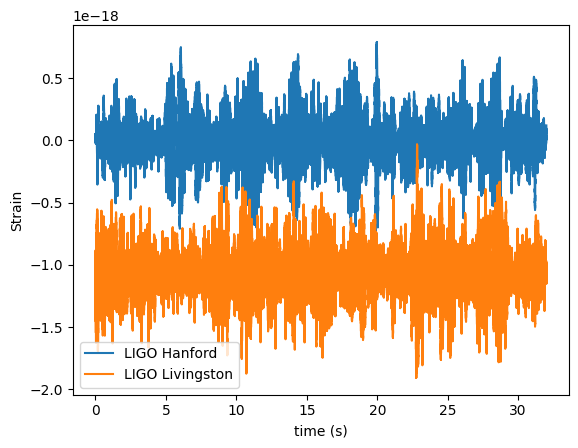

In [2]:
plt.plot(tn,fn1,label='LIGO Hanford')
plt.plot(tn,fn2,label='LIGO Livingston')

plt.xlabel('time (s)')
plt.ylabel('Strain')

plt.legend(loc='lower left')
plt.show()

Obviously, we can't see by eye anything yet. This is a job for spectral analysis!

Let's make spectrograms for the two datasets. This is just to show that GW150914 was such a whopping big signal that it can be seen straight from the raw data.

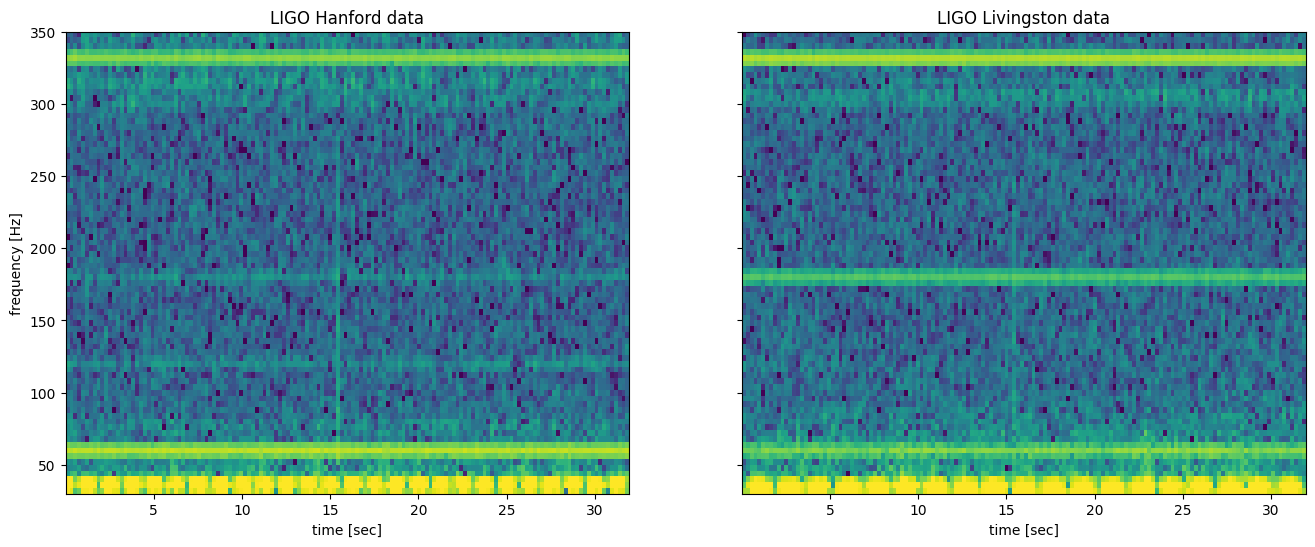

In [3]:
from scipy import signal

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,6))

# Make spectrogram for Hanford data
freq, time, power_spec = signal.spectrogram(fn1, sample_rate, window='hann', nperseg=4096)

# Plot the spectrogram
ax1.pcolormesh(time, freq, np.log10(power_spec), vmin=-48, vmax=-43)
ax1.set_ylabel('frequency [Hz]')
ax1.set_xlabel('time [sec]')
ax1.set_title('LIGO Hanford data')
plt.ylim([30,350])
# plt.show()

# Make spectrogram for Livingston data
freq, time, power_spec = signal.spectrogram(fn2, sample_rate, window='hann', nperseg=4096)

ax2.pcolormesh(time, freq, np.log10(power_spec), vmin=-48, vmax=-43)
ax2.set_title('LIGO Livingston data')
ax2.set_xlabel('time [sec]')

plt.show()

Notice the following:
- There are some prominent horizontal bands. This is noise. It turns out that various sources of noise can contribute with a characteristic frequency. For example, noise at 60 Hz is related to the AC power supply.
- Around the 15-16 s mark, there is a clear vertical line. That is the BH event! We expected a *chirp*, that the frequency is rising as a function of time. Here, plotted over a scale of 32 s, the frequency is rising so steeply that it is simply a vertical line. (see below that the chirp happens over a time scale of less than 0.1 s.)


## <font color=#46769B>Section I: Signal Processing and Gravitational Wave Data [35 points total]</font>

Now that we have introduced the LIGO data, the goal here is to investigate the the chirp signal from GW150914 in more detail. Obviously, we don't have much information so far except the time it occurred and the fact that it seemed to span frequencies between 50-300 Hz.

## <font color=#46769B>Part (a): Processing the LIGO data</font>

Our next goal is to process the raw data into a form where the BH event is easily visible above the noise. Specifically, we will apply a series of signal-processing steps summarized in this figure:

<img src="https://inspirehep.net/files/740837278b6d562fad5b6ec6cf268515" width="600">

This figure is from [A guide to LIGO-Virgo detector noise and extraction of transient gravitational-wave signals](https://arxiv.org/abs/1908.11170) and is nicely discussed in this [blog post](https://cplberry.com/2020/02/09/gw-data-guides/).

Below are the tasks you need to perform. You are meant to perform these steps for *both* Hanford and Livingston datasets, thereby producing two versions of the above plots. In the final plot (black), the BH signal is finally visible as a spike above the noise.

### <font color=#46769B>Step 1: Selecting the signal region [5 points]</font>

First, select out a segment of the samples, `fn1_signal` and `fn2_signal`, to represent the signal region where the gravitational wave event has occured. Since we know from the spectrogram above that the signal happened around a time of $15-16$ seconds, your segments must cover the 4s window

$$13 \; {\rm s} \le t < 17 \; {\rm s} \, .$$

Note your segments should have exactly `4*sample_rate` elements. Plot the strain as a function of time. (This is the top blue plot above.)

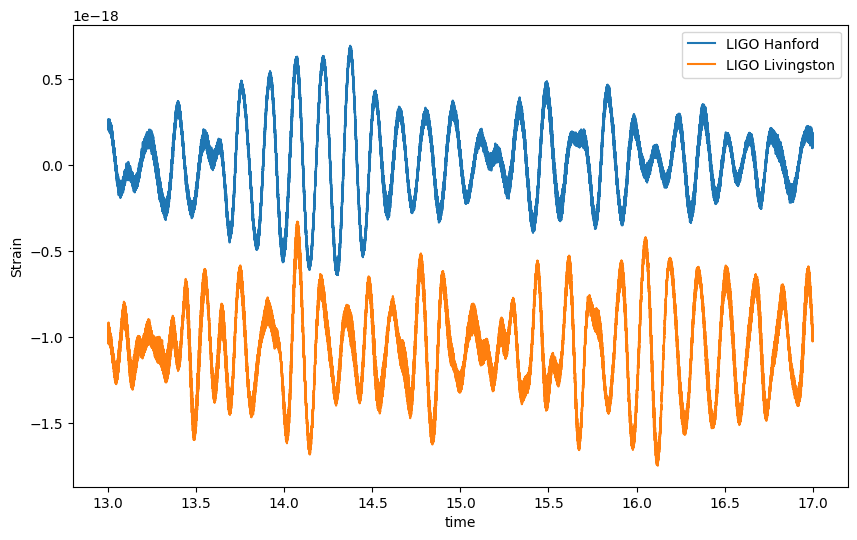

In [4]:
# Your code here for Part (a) Step 1
t0=13
tf=17

fn1_signal=fn1[(np.where(tn==t0)[0][0]):(np.where(tn==tf)[0][0])]
fn2_signal=fn2[(np.where(tn==t0)[0][0]):(np.where(tn==tf)[0][0])]
tn_signal=np.arange(t0,tf,h)


len(tn_signal)==(4*(sample_rate)) , len(fn1_signal)==(4*(sample_rate))
# the segment has 1*sample_rate elements

plt.figure(figsize=(10, 6))
plt.plot(tn_signal,fn1_signal,label='LIGO Hanford')
plt.plot(tn_signal,fn2_signal,label='LIGO Livingston')
plt.xlabel('time')
plt.ylabel('Strain')
plt.legend()
plt.show()

### <font color=#46769B>Step 2: Windowing the signal [5 points]</font>

From the signal samples in Part (a), `fn1_signal` and `fn2_signal`, perform the following tasks:

- First, subtract off the mean value of each array to yield two new arrays.

- Next, apply a window function to the mean-subtracted samples to yield two new arrays, `fn1_signal_windowed` and `fn2_signal_windowed`. Use a `tukey` window function with `alpha=0.25`. Plot the strain as a function of time for these new arrays. (This is the green plot above.)

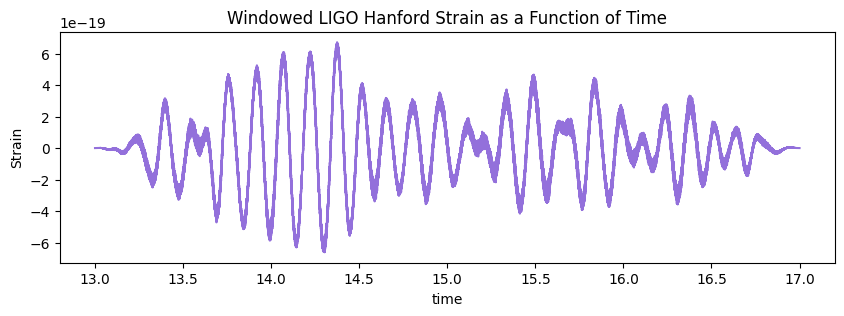

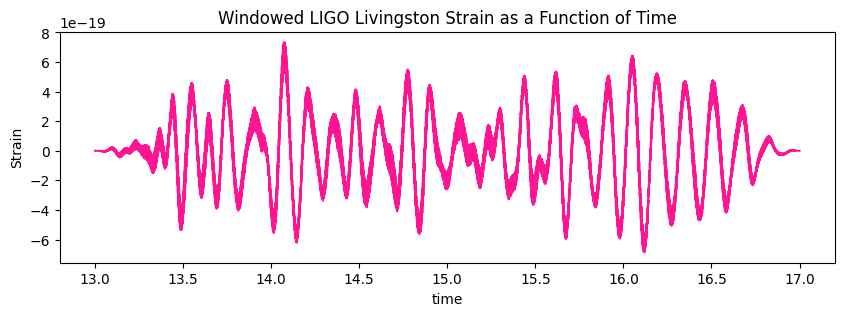

In [5]:
from scipy import signal

fn1_signal-=np.mean(fn1_signal)
fn2_signal-=np.mean(fn2_signal)

alpha=0.25
wn=signal.windows.tukey(len(fn1_signal),alpha)


fn1_signal_windowed=fn1_signal * wn
fn2_signal_windowed=fn2_signal * wn

plt.figure(figsize=(10, 3))
plt.plot(tn_signal,fn1_signal_windowed,color='mediumpurple')
plt.xlabel('time')
plt.ylabel('Strain')
plt.title('Windowed LIGO Hanford Strain as a Function of Time')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(tn_signal,fn2_signal_windowed,color='deeppink')
plt.xlabel('time')
plt.ylabel('Strain')
plt.title('Windowed LIGO Livingston Strain as a Function of Time')
plt.show()


### <font color=#46769B>Step 3: Whitening the signal [5 points]</font>

Apply a process known as [__whitening__](https://en.wikipedia.org/wiki/Whitening_transformation) to your windowed signals, `fn1_signal_windowed` and `fn2_signal_windowed` from above. The idea is to apply a tranformation that can make LIGO noise (which is a complicated function of frequency) look more like white noise (which has equal intensity as a function of frequency). The purpose is that by making the noise more uniform, a signal will appear as an genuine excess above the background noise.

The tasks must follow to implement whitening are as follows:

- Calculate the Fourier coefficients $c_k^{\rm signal}$ from the signal samples by taking the DFT of the windowed samples in Part (b).

- Rescale the Fourier coefficients by dividing by the square root of the mean power $P_k^{\rm mean}$:

$$c^{\rm whitened}_k = \frac{c_k^{\rm signal}}{\sqrt{P_k^{\rm mean}}}$$

- Compute *whitened* samples `fn1_whitened` and `fn2_whitened` by taking the IDFT of your whitened Fourier coefficients.

- Plot samples `fn1_whitened` and `fn2_whitened` as a function of time. (This is the red plot above. Note the overall amplitude of the Fourier coefficients is dependent on convention,

To calculate the mean power, follow these steps:

- From each of your original samples `fn1` and `fn2` (each 32 sec), divide the samples into 8 adjacent segments, each 4 sec long (i.e. the same duration as the signal region).

- Calculate the power spectrum of each 4-sec segment, applying a Tukey window function with `alpha=0.25` as in the signal.

- In total, we have 8 power spectra $P_k^{(1)}$, ..., $P_k^{(8)}$ (for each detector). Calculate the mean power by averaging over all 8 power spectra:

$$P_k^{\rm mean} = \frac{1}{8} \sum_{a=1}^8 P_k^{(a)} \, .$$

Note that you apply this process separately for *each detector*. Also, be sure that $P_k^{\rm mean}$ is an array of the same length as $c_k$, i.e., you don't take the mean over all the $k$ modes.

Technically, the signal region treated as part of the noise, but it makes up only very small fraction of the total time, so it suffices to not worry about that here.


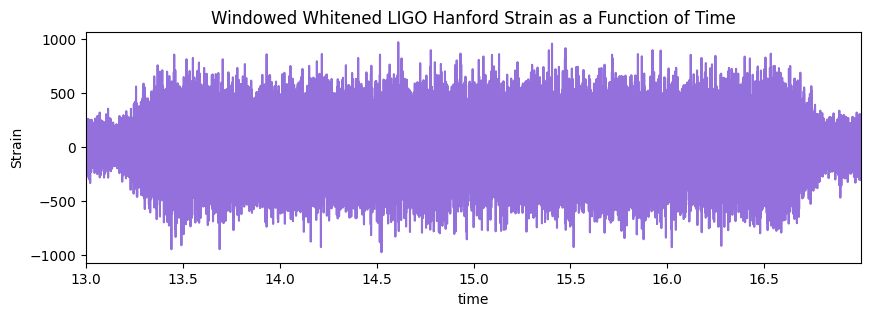

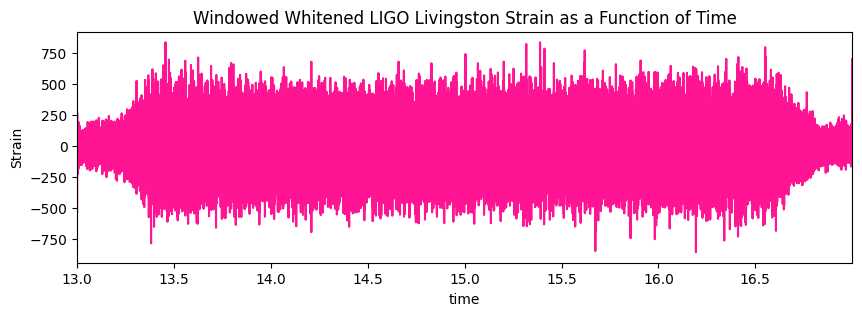

In [6]:
from scipy import fft

ck1=fft.fft(fn1_signal_windowed,norm='forward')
ck2=fft.fft(fn2_signal_windowed,norm='forward')

M=4*sample_rate
Q=8

P_spec1=[]
P_spec2=[]

for i in range(Q):
  x1=fn1[i*M:(i+1)*M]
  x2=fn2[i*M:(i+1)*M]

  vk1,Pk1=signal.periodogram(x1,fs=sample_rate,window='tukey',return_onesided=False,scaling='spectrum')
  vk2,Pk2=signal.periodogram(x2,fs=sample_rate,window='tukey',return_onesided=False,scaling='spectrum')

  P_spec1.append(Pk1)
  P_spec2.append(Pk2)

Pk1_mean=np.mean(P_spec1,axis=0)
Pk2_mean=np.mean(P_spec2,axis=0)

ck1_whitened=ck1/np.sqrt(Pk1_mean)
ck2_whitened=ck2/np.sqrt(Pk2_mean)

fn1_whitened=fft.ifft(ck1_whitened,norm='forward').real
fn2_whitened=fft.ifft(ck2_whitened,norm='forward').real

plt.figure(figsize=(10,3))
plt.plot(tn_signal,fn1_whitened,color='mediumpurple')
plt.xlim(tn_signal[0],tn_signal[-1])
plt.xlabel('time')
plt.ylabel('Strain')
plt.title('Windowed Whitened LIGO Hanford Strain as a Function of Time')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(tn_signal,fn2_whitened,color='deeppink')
plt.xlim(tn_signal[0],tn_signal[-1])
plt.xlabel('time')
plt.ylabel('Strain')
plt.title('Windowed Whitened LIGO Livingston Strain as a Function of Time')
plt.show()


### <font color=#46769B>Step 4: Filtering the signal [5 points]</font>

Finally, apply an ideal bandpass filter to your whitened Fourier coefficients $c_k^{\rm whitened}$ over the range of frequencies

$$ 35 \; {\rm Hz} \le |\nu_k| \le 300 \; {\rm Hz}$$

Perform an inverse DFT to compute (finally) the whitened, bandpassed signal: `fn1_bandpass` and `fn2_bandpass`. Make a plot of these samples vs time. (This is the black plot above.)

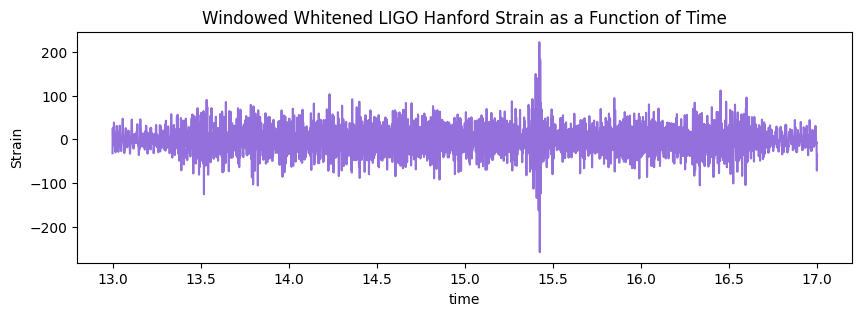

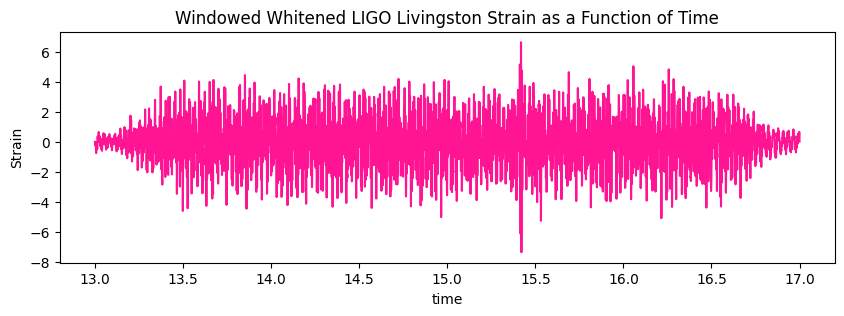

In [7]:
# Your code here for Part (a) Step 4

freq=np.fft.fftfreq(len(fn1_whitened),1/sample_rate)

gk= (np.abs(freq)<=300) & (35<=np.abs(freq))

ck1_bandpass=ck1_whitened*gk
ck2_bandpass=ck2_whitened*gk

fn1_bandpass=np.fft.ifft(ck1_bandpass,norm='forward').real
fn2_bandpass=np.fft.ifft(ck2_bandpass,norm='forward').real

plt.figure(figsize=(10,3))
plt.plot(tn_signal,fn1_bandpass.real,color='mediumpurple')
plt.xlabel('time')
plt.ylabel('Strain')
plt.title('Windowed Whitened LIGO Hanford Strain as a Function of Time')
plt.show()

plt.figure(figsize=(10,3))
plt.plot(tn_signal,fn2_bandpass.real,color='deeppink')
plt.xlabel('time')
plt.ylabel('Strain')
plt.title('Windowed Whitened LIGO Livingston Strain as a Function of Time')
plt.show()

## <font color=#46769B>Part (b): Measuring the Black Hole Mass</font>

Next, we will perform a simplified analysis of the chirp signal to extract a quantity known as the [__chirp mass__](https://en.wikipedia.org/wiki/Chirp_mass). The chirp mass is an effective mass parameter

$$\mathcal{M}_{\rm chirp} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}}$$

where $m_1$ and $m_2$ are the two BH masses. If the two BHs are of equal mass, then $\mathcal{M}_{\rm chirp} \approx 0.87 \, m_{1,2}$. Chirp mass, therefore, is comparable to the BH masses.

The chirp mass is extracted from the derivative of the frequency (how the oscillations are speeding up in time) according to the remarkable formula

$$\frac{d \nu_{\rm signal}}{dt} = \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} \nu^{11/3}_{\rm signal} \qquad (1)$$

where $\nu_{\rm signal}$ is the frequency of oscillations extracted from the BH merger event in the LIGO data, $G$ is Newton's constant, and $c$ is the speed of light.

### <font color=#46769B>Physics derivation</font>

For the interested reader, we can derive Eq. (1). We will work under the simplifying assumption of equal masses, $m_1 = m_2 = m$. (For a higher-level but very readable discussion of the basic physics of GW150914 and BH-BH mergers, [this reference](https://arxiv.org/abs/1608.01940) is very recommended.)

Eq. (1) looks complicated, but actually most of the physics is familiar from introductory classical mechanics. There are two inputs needed:
- The two masses are in (approximate) circular motion. We apply the usual formulas from introductory classical mechanics for circular motion.
- There is a famous formula due to Einstein for the power (energy-per-unit-time) emitted in gravitational waves by two bodies in circular motion (here assumed to be equal in mass):
$$P_{\rm emit} = \frac{8}{5} \frac{G}{c^5} m^2 r^4 \omega^6$$
where $r$ is the separation distance between the two masses and $\omega$ is the orbital frequency. This formula is derived from General Relativity.

Now we consider circular motion for two equal masses. Assuming both masses orbit around a fixed center of mass, the total kinetic energy is $T = \tfrac{1}{2} m v_1^2 + \tfrac{1}{2} m v_2^2$. The potential energy is $U = - \frac{G m^2}{r}$.
Setting the centripetal force equal to the gravitational force, we have

$$\frac{2 m v_1^2}{r} = \frac{2 m v_2^2}{r} = \frac{G m^2}{r^2}$$

where the extra factors of $2$ follow from the fact that both masses are orbiting at a distance $\frac{r}{2}$ from the origin. Solving for $v_1^2$ and $v_2^2$ in terms of $r$ yields that the total energy is $E = T + U = - G m^2/(2r)$. The centripetal force is also equal to

$$\frac{m \omega^2 r }{2} = \frac{G m^2}{r^2}$$

which implies $\omega^2 = 2 G m/r^3$ (Kepler's Law). With this expression, we have the following formula for $E$:

$$E = - \left( \frac{G^2 m^5 \omega^2}{16} \right)^{1/3}$$

Finally, we set the rate-of-change in $E$ equal to the power lost via gravitational waves:

$$\frac{dE}{dt} = - P_{\rm emit}$$

Plugging in the formulas for $E$ and $P_{\rm emit}$, we have:

$$- \frac{d}{dt} \left( \frac{G^2 m^5 \omega^2}{16} \right)^{1/3} = - \frac{8}{5} \frac{G}{c^5} m^2 r^4 \omega^6$$

The derivative on the left-hand side acts on $\omega(t)$, and after some algebra, we have:

$$\frac{d \omega}{dt} = \frac{96}{5} \frac{1}{2^{1/3}} \left( \frac{G m}{c^3} \right)^{5/3} \omega^{11/3}$$

Lastly, we set $\omega = \pi \nu$, where $\nu$ is the frequency of the gravitational wave signal. Expressing this in terms of $\nu$ yields Eq. (1) in the equal mass limit, where $\mathcal{M}_{\rm chirp} = \tfrac{1}{2^{1/5}} m$.

Finally, note that you may be tempted to write $\omega = 2\pi \nu$, but this is not correct here: $\omega$ is the orbital period and $\nu$ is the frequency of the gravitational waves. Gravitational waves oscillate twice as fast as each mass orbits around. This is because one period of the gravitational wave is completed when $m_1$ and $m_2$ swap places (half an orbit).

### <font color=#46769B>Step 1: Plot the chirp signal [5 points]</font>

After the steps in Section I, the BH event should be visible as a prominent peak. Using the bandpassed, whitened samples from Part (a), `fn1_bandpass` and `fn2_bandpass`, plot the strain as a function of time over a 0.1 second time window located to cover the gravitational wave event.
- Plot the Hanford and Livingston data on the same plot.
- Apply a time shift and amplitude rescaling to the Livingston data so that both events look as similar as possible.

That is, do the following:
```py
plt.plot(t,fn1_whitened_bandpassed,label='Hanford')
plt.plot(t+tshift,rescaling*fn2_whitened_bandpassed,label='Livingston')
plt.xlim([xmin,xmin+0.1])
plt.legend()
plt.show()
```
where `tshift` and `rescaling` are numbers that you can choose by eye so that the two plots line up as best as possible. (Note: `tshift` should be of order the light-travel time between the two detectors, 0.01 s, and can be positive or negative.)

The waveforms for both plots should look similar, appearing as an oscillating function that oscillates faster and faster until it ends. This corresponds to BHs orbiting faster and faster as they inspiral until they finally merge together.

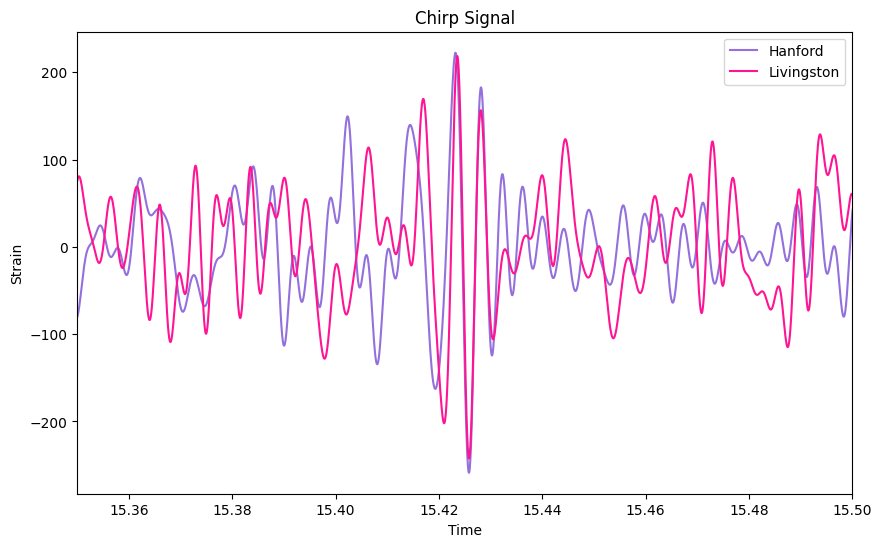

In [8]:
# Your code here for Part (b) Step 1

tshift=0.005
rescaling=33

plt.figure(figsize=(10,6))
plt.plot(tn_signal,fn1_bandpass,label='Hanford',color='mediumpurple')
plt.plot(tn_signal+tshift,rescaling*fn2_bandpass,label='Livingston',color='deeppink')
plt.xlim([15.35,15.4+0.1])
plt.legend()
plt.xlabel('Time')
plt.ylabel('Strain')
plt.title('Chirp Signal')
plt.show()

### <font color=#46769B>Step 2: Chirp mass [10 points]</font>

To extract $\mathcal{M}_{\rm chirp}$, we start with Eq. (1) and plug in the known constants, giving the expression

$$\frac{d \nu_{\rm signal}}{dt} = 5.8 \times 10^{-7} \mathcal{M}_{\rm chirp}^{5/3} \nu_{\rm signal}^{11/3} \qquad (2)$$

where $\nu_{\rm signal}$ is the signal frequency in units of ${\rm Hz}$ and $\mathcal{M}_{\rm chirp}$ is in units of $M_\odot$.

There is a nice trick for solving Eq. (2) using the data that avoids numerically computing the derivative of $\nu_{\rm signal}$. The argument is outlined [here](https://arxiv.org/pdf/1510.02426.pdf) (also noted [here](https://en.wikipedia.org/wiki/Chirp_mass#cite_note-7)).

First, let's define

$$y = \frac{3}{8} \nu_{\rm signal}^{-8/3}$$

Then we can take the derivative with respect to time, using Eq. (2):

$$\frac{dy}{dt} = - \nu_{\rm signal}^{-11/3} \times \frac{d \nu_{\rm signal}}{dt} = - 5.8 \times 10^{-7} \mathcal{M}_{\rm chirp}^{5/3}$$

That is, the slope of $y(t)$ is constant and is proportional to the chirp mass.

The strategy is as follows:

- Determine $y$ as a function of $t$ numerically from the chirp signal.

- Fit with a $y$ as a function of $t$ with a straight line, $y = M t + B$.

- The fitted slope $M$ of this straight line gives us the chirp mass.

Here are the tasks you are to perform:

1. Determine (numerically) the $t$ values of the most prominent five or so extrema (minima and maxima) in the chirp signal and save this to a list or array, `t_extrema_list`.

2. Calculate the period $T$ for the signal as a function of $t$. The period is twice the distance between adjacent extrema. Save the period values to a list or array, `T_list`. Set the corresponding times to be the mid-times between adjacent extrema and save these values to a list or array, `t_list`.

3. From the $T$ values, determine the $y$ values and save these to an list or array, `y_list`.

4. Fit a straight-line of the form $y = M t + B$ through your data of `y_list` vs `t_list`. From the slope $M$, determine the chirp mass from the formula

$${\rm slope} \; M = - 5.8 \times 10^{-7} \mathcal{M}_{\rm chirp}^{5/3}$$

5. Repeat the analysis for both Hanford and Livingston data separately.

*The answer you should find is: $m_{\rm chirp} \approx 30 \; M_\odot$.*

In [9]:
def t_extrema(fn):
  tn_extrema=[]
  fn_extrema=[]
  t_extrema_list=[]

  for i in range(len(fn)):

    if i==0:
      left_value=fn[i]
    else:
      left_value=fn[i-1]

    if i==len(fn)-1:
      right_value=fn[i]
    else:
      right_value=fn[i+1]


    if fn[i]>left_value and fn[i]>right_value:
      fn_extrema.append(np.abs(fn[i]))
      tn_extrema.append(tn_signal[i])

    elif fn[i]<left_value and fn[i]<right_value:
      fn_extrema.append(np.abs(fn[i]))
      tn_extrema.append(tn_signal[i])

  fn_extrema_sorted=sorted(fn_extrema)[-5:]

  for extrema in fn_extrema_sorted:
    t_extrema_list.append(tn_extrema[fn_extrema.index(extrema)])

  return t_extrema_list


def T_t(fn):
  T_list=[]
  t_list=[]
  t_extrema_list=t_extrema(fn)

  for i in range(len(t_extrema_list)-1):
    T_list.append(np.abs(2*(t_extrema_list[i+1]-t_extrema_list[i])))
    t_list.append(np.abs((t_extrema_list[i]+t_extrema_list[i+1])/2))

  return np.array(T_list), np.array(t_list)

T1,t1=T_t(fn1_signal)
T2,t2=T_t(fn2_signal)

y1_list = [(3/8) * (T ** (8/3)) for T in T1]
y2_list = [(3/8) * (T ** (8/3)) for T in T2]

M1,B1 = np.polyfit(t1, y1_list, 1)
M2,B2 = np.polyfit(t2, y2_list, 1)

M_chirp1=(M1*(-5.8e7))**(3/5)
m_chirp1=M_chirp1*(2**(1/5))/10

M_chirp2=(-M2*(-5.8e7))**(3/5)
m_chirp2=M_chirp2*(2**(1/5))/10



print("Chirp Mass (Hanford):", m_chirp1,'Msun')
print("Chirp Mass (Livingston):", m_chirp2,'Msun')

Chirp Mass (Hanford): 22.537502561542123 Msun
Chirp Mass (Livingston): 33.47638651684613 Msun


## <font color=#46769B>Section II: Binary Black Hole Dynamics [30 points total]</font>

Gravitational wave signals result from pairs of black holes (BHs) that orbit around each other. As they emit gravitational waves, they lose energy and spiral inward, orbiting faster and faster until they collide. This is the __inspiral phase__.

There is another part of the gravitational wave signal: the merger and post-merger phase where the combined object resulting from the violent collision settles down (by emitting more gravitational waves) to form a new BH of mass almost equal to the sum of the two BHs that collided. *Almost* but not quite equal because a few solar masses worth of energy (!) is radiated in the form of gravitational waves.

In this Section, we will calculate the gravitational wave signal that results from two equal-mass BHs during the inspiral phase. To date, only the inspiral phase of binary BH mergers has been observed in LIGO. The merger and post-merger part of the signals have not yet been measured, as far as I'm aware. A proper treatment of the entire process is based on General Relativity, but here we will consider a much simplified treatment based on Newtonian dynamics.

We will consider two equal-mass BHs, labeled by $1$ and $2$, each with mass $m=35 \, M_\odot$, in (nearly) circular motion. We start with Newton's second law:

$$\ddot{\mathbf{r}}_1(t) = \frac{\mathbf F_1}{m} \, , \quad \ddot{\mathbf{r}}_2(t) = \frac{\mathbf F_2}{m} \qquad (1) $$

We will use $\mathbf{r}_{1,2}(t)$ and $\mathbf{v}_{1,2}(t)$ to be the position and velocity vectors of the two BHs as a function of time. Assuming circular motion around a fixed center of mass, we have $\mathbf{r}_1 = - \mathbf{r}_2$ and $\mathbf{v}_1 = - \mathbf{v}_2$. $\mathbf{F}_{1,2}$ are the forces acting on each BH and we will consider two contributions to the force:

$$\mathbf{F}_{1,2} = \mathbf{F}_{1,2}^{\rm grav} + \mathbf{F}_{1,2}^{\rm drag} \, .$$

Here, the usual force for Newtonian gravitation is

$$\mathbf{F}_{1}^{\rm grav} = - \mathbf{F}_{2}^{\rm grav} = \frac{G m^2 \mathbf{r}_{21}}{|\mathbf r_{21}|^3} \qquad (2)$$

where $\mathbf{r}_{12} = \mathbf{r}_1 - \mathbf{r}_2$ is the relative position between the two BHs.

We also include a drag force $\mathbf{F}_{1,2}^{\rm drag}$ that acts on the BHs as a simplified way of treating energy loss, which leads to inspiraling circular orbits. We recall that power $P = \mathbf{F} \cdot \mathbf{v}$. Therefore, the change in energy per unit time for both BHs is

$$P_{\rm BHs} = \mathbf{F}_1^{\rm drag} \cdot \mathbf{v}_1 + \mathbf{F}_2^{\rm drag} \cdot \mathbf{v}_2 \, .$$

Einstein's famous formula for power emitted by gravitational waves for masses in circular orbits is

$$P_{\rm emit} = \frac{8}{5} \frac{G}{c^5} m^2 r^4 \omega^6$$

where $\omega$ is the orbital frequency, $\omega = |\mathbf{v}_1|/|\mathbf{r_1}| = |\mathbf{v}_2|/|\mathbf{r_2}|$, and $r = |\mathbf{r}_{21}|$ is the separation distance between the masses. The idea is to assume that $P_{\rm BHs} = - P_{\rm emit}$, i.e., the energy loss of the BHs is equal to the energy emitted in gravitational waves. The drag forces are taken to be

$$\mathbf{F}_{1}^{\rm drag} = - \frac{256}{5} \frac{G}{c^5} m^2 \frac{|\mathbf v_1|^4}{|\mathbf r_{12}|^2} \mathbf{v}_{1} \, , \quad
\mathbf{F}_{2}^{\rm drag} = - \frac{256}{5} \frac{G}{c^5} m^2 \frac{|\mathbf v_2|^4}{|\mathbf r_{12}|^2} \mathbf{v}_{2} \, .\qquad (3)$$

such that the radiated power agrees with Einstein's formula. In showing that Eq. (3) agrees with Einstein's formula, recall there are extra factors of $2$ that are important, since $\omega = 2|\mathbf v_1|/r = 2|\mathbf v_2|/r$.


## <font color=#46769B>Part (a) [15 points]</font>

Consider two BHs, with equal mass $m=35 \; M_\odot$, starting at $t_0=0$ with initial displacements and velocities describing circular motion in the $x$-$y$ plane, about the origin:

$$\mathbf{r}_1(0) = (\tfrac{d}{2},0,0) \, , \quad \mathbf{r}_2(0) = (-\tfrac{d}{2},0,0) \, , \quad
\mathbf{v}_1(0) = (0,\sqrt{\tfrac{Gm}{2d}},0) \, , \quad \mathbf{v}_2(0) = (0,-\sqrt{\tfrac{Gm}{2d}},0) \, ,$$

where $d = 10^6 \; {\rm m}$ is their initial separation. Write a code to solve Eq. (1) for $\mathbf{r}_1$, $\mathbf{r}_2$, $\mathbf{v}_1$, $\mathbf{v}_2$ as a function of time $t$, from $t_0 = 0$ to $t_f = 1 \; {\rm sec}$.
Be sure that you include both the gravitational force defined in Eq. (2) and the drag force defined in Eq. (3).

Due to energy loss, the BHs will inspiral (orbiting faster and faster) and eventually merge. The merger condition is defined by

$$|\mathbf{r}_{12}| < 2r_s \, ,$$

where the quantity $r_s = \frac{2 G m}{c^2}$ is the [Schwarzschild radius](https://en.wikipedia.org/wiki/Schwarzschild_radius), which is the radius of the BH event horizon. When the BHs are within $2r_s$ of each other, their event horizons have merged together and they are effectively touching. You should find that the merger happens at some time $t_{\rm merge}$ *before* $t_f$.

Your tasks are as follows:
- Using the RK4 method, with $N = 10^4$ steps, solve Eq. (1), with forces defined in Eq. (2) and (3).

- Include the merger condition in your RK4 algorithm such that:
    - When the merger occurs, your `for` loop iteration stops.
    
- Print $t_{\rm merge}$.


In [10]:
# Some inputs
G = 6.6743e-11 # m^3/s^2/kg
Msol = 1.99e30 # kg
m = 35 * Msol # BH mass
d = 1e6 # meters
c = 3e8 # m/s

# Time steps
t0, tf = 0, 1
N = 10**4

# Your code here
rs=2*G*m/(c**2)

r1_0=[d/2,0,0]
r2_0=[-d/2,0,0]
r0=r1_0+r2_0

v1_0 = [0, np.sqrt(G * m / (2 * d)), 0]
v2_0 = [0, -np.sqrt(G * m / (2 * d)), 0]
v0 = v1_0+v2_0

y0=r0+v0


def F_grav(r):
  r_magnitude=np.linalg.norm(r)
  return -G*(m**2)*r/(r_magnitude**3)

def F_drag(v,r):
    v_mag=np.linalg.norm(v)
    r_magnitude=np.linalg.norm(r)
    return -256*G*(m**2)*(v_mag**4)*v/(5*(c**5)*(r_magnitude**2))

def f(t, y):
    r1, r2 = y[:3], y[3:6]
    v1, v2 = y[6:9], y[9:]
    r12 = r1 - r2
    F_grav1=F_grav(r12)
    F_grav2=-F_grav1
    F_drag1=F_drag(v1, r12)
    F_drag2=-F_drag1
    y2 = np.concatenate([v1, v2, (F_grav1 + F_drag1) / m, (F_grav2 + F_drag2) / m])
    return np.array(y2)

def RK4(N, y0):
    t = np.linspace(t0, tf, num=N+1)
    y = np.zeros((N+1, 12))
    y[0] = y0
    h = t[1] - t[0]
    t_merge=0
    for i in range(N):
        k1 = f(t[i], y[i])
        k2 = f(t[i] + h/2, y[i] + ((h/2) * k1))
        k3 = f(t[i] + h/2, y[i] + ((h/2) * k2))
        k4 = f(t[i] + h, y[i] + (h * k3))
        k = (1/6) * (k1 + (2*k2) + (2*k3) + k4)
        y[i+1] = y[i] + h * k

        if np.linalg.norm(y[i+1, :3] - y[i+1, 3:6]) < 2*rs:
            t_merge+=t[i+1]
            break
    return t,y,t_merge


t,y,t_merge=RK4(N,y0)

print(f't_merge: {t_merge} s.')


t_merge: 0.24180000000000001 s.


<!-- ## <font color=#46769B>Part (b) [15 points]</font> -->

Using your numerical solution from Part (a), make the following plots:
- Plot $x_1(t)$ and $x_2(t)$ vs $t$, for time in the range $[t_0,t_{\rm merge}]$. Include a legend.

- Make a phase portrait plot of $x_1(t)$ vs $y_1(t)$ and $x_2(t)$ vs $y_2(t)$, for $t$ in the range $[t_0,t_{\rm merge}]$. Make the plot square in shape and include a legend.

- Make a plot of the orbital angular frequency for BH $1$, $\omega = |\mathbf{v}_1|/|\mathbf{r}_1|$, as a function of time over the range $[t_0,t_{\rm merge}]$.

- The frequency of the gravitational wave signal observed by the LIGO detectors is $\nu_{\rm signal} = \omega/\pi$. Plot $\nu_{\rm signal}$ as a function of time over the range $[t_0,t_{\rm merge}]$. You should observe a frequency rising with time, characteristic of the chirp signal.

- Plot the power emitted in gravitational waves in SI units (Watts) as a function of time.

In all your plots, include axes labels with the appropriate SI units.

Lastly, calculate (and print) the total energy radiated over the time interval $[t_0,t_{\rm merge}]$ in SI units (Joules). For reference, the rest mass energy of the sun (!) is $M_\odot c^2 \approx 2\times 10^{47} \; {\rm Joules}$.

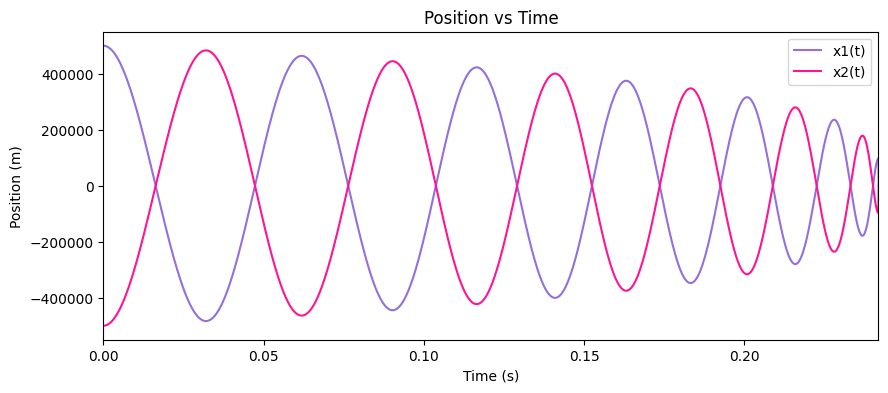

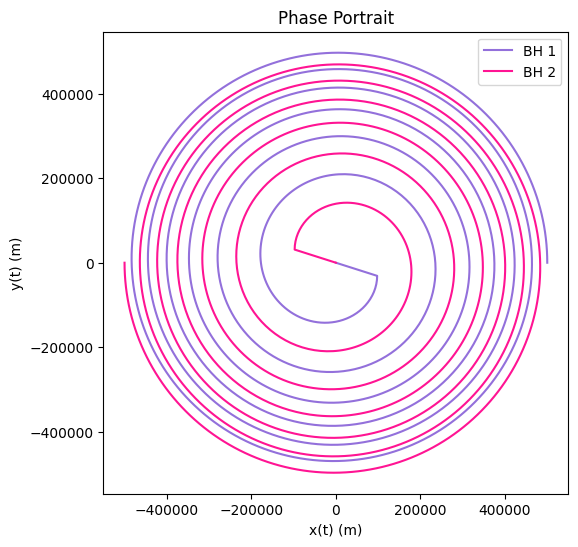

<ipython-input-11-748966875467>:30: RuntimeWarning: invalid value encountered in divide
  omega=v1/r1


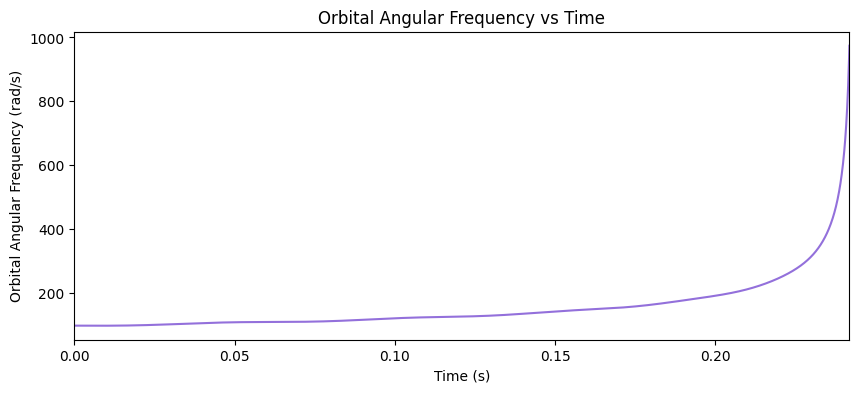

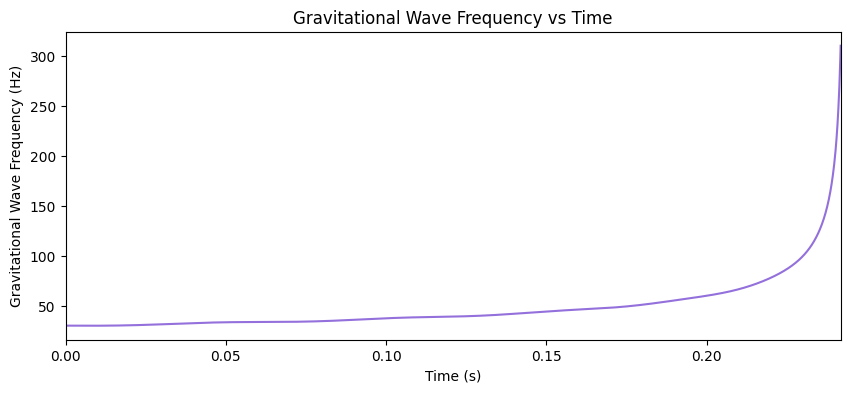

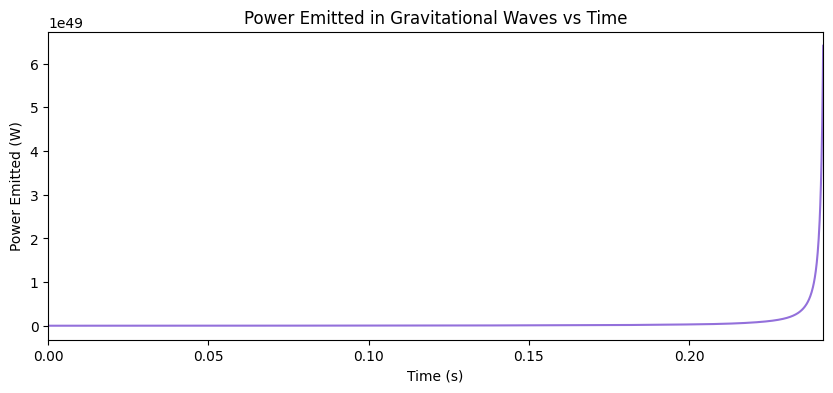

Total energy radiated up to merging: [1.5501067e+49] Joules


In [11]:
x1=y[:,0]
x2=y[:,3]
y1=y[:,1]
y2=y[:,4]

v1 = np.linalg.norm(y[:, 6:9], axis=1)
r1 = np.linalg.norm(y[:, :3], axis=1)

plt.figure(figsize=(10, 4))
plt.plot(t, x1, label='x1(t)',color='mediumpurple')
plt.plot(t, x2, label='x2(t)',color='deeppink')
plt.xlim(0,t_merge)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs Time')
plt.legend()
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(x1, y1, label='BH 1',color='mediumpurple')
plt.plot(x2, y2, label='BH 2',color='deeppink')
plt.xlim(0,t_merge)
plt.xlabel('x(t) (m)')
plt.ylabel('y(t) (m)')
plt.title('Phase Portrait')
plt.legend()
plt.axis('equal')
plt.show()

omega=v1/r1

plt.figure(figsize=(10, 4))
plt.plot(t, omega,color='mediumpurple')
plt.xlim(0,t_merge)
plt.xlabel('Time (s)')
plt.ylabel('Orbital Angular Frequency (rad/s)')
plt.title('Orbital Angular Frequency vs Time')
plt.show()

nu_signal=omega/np.pi

plt.figure(figsize=(10, 4))
plt.plot(t, nu_signal,color='mediumpurple')
plt.xlim(0,t_merge)
plt.xlabel('Time (s)')
plt.ylabel('Gravitational Wave Frequency (Hz)')
plt.title('Gravitational Wave Frequency vs Time')
plt.show()


P_emit=(8/5)*G*(m**2)*((np.linalg.norm(y[:, :3] - y[:, 3:6], axis=1))**4)*(omega**6)/(5*(c**5))

plt.figure(figsize=(10, 4))
plt.plot(t, P_emit,color='mediumpurple')
plt.xlim(0,t_merge)
plt.xlabel('Time (s)')
plt.ylabel('Power Emitted (W)')
plt.title('Power Emitted in Gravitational Waves vs Time')
plt.show()

E_radiated = P_emit[np.where(t==t_merge)[0]]*t_merge
print("Total energy radiated up to merging:", E_radiated, "Joules")


## <font color=#46769B>Section III: Waveform Template Matching [35 points total]</font>

The LIGO collaboration uses a procedure for extracting the black hole (BH) parameters known as __template matching__. The basic idea to have a functional form that describes the gravitational waveform, which depends on parameters that we wish to measure. Then we test which waveforms are good fits to the data, and that tells us the values of the parameters. Here, the parameter we want to extract is the __chirp mass__ $\mathcal{M}_{\rm chirp}$.

Here we load and plot the strain data, $f_n^{\rm signal}$, evaluated at the sample times $t_n$. The Hanford and Livingston data are offset by $\pm 2$ so that the two datasets are more clear on the same plot. The data has been whitened, following the procedure in Sec. I and clipped to an interval $\sim 0.2 \; {\rm s}$ around the chirp signal. The data has also been rescaled by an overall constant. It should appear similar to the signal you considered in Section I.

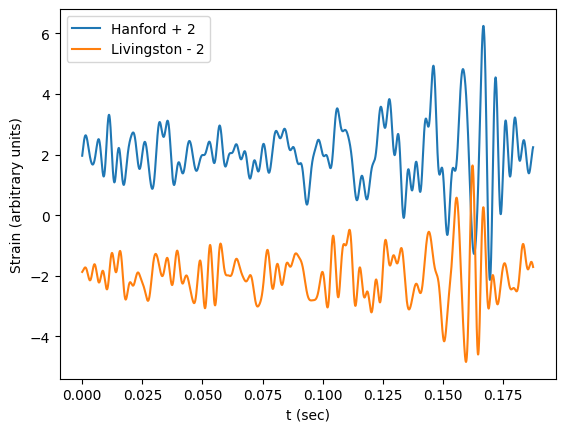

In [12]:
import urllib.request

path = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/signal1_Hanford.npy?raw=true"
tmp_file = urllib.request.urlretrieve(path)[0]
tn, fn1_signal = np.load(tmp_file)

path = "https://github.com/PHYS-2030-Computational-Methods/Lecture-notes/blob/main/data/signal2_Livingston.npy?raw=true"
tmp_file = urllib.request.urlretrieve(path)[0]
tn, fn2_signal = np.load(tmp_file)

plt.plot(tn,fn1_signal+2,label='Hanford + 2')
plt.plot(tn,fn2_signal-2,label='Livingston - 2')

plt.xlabel('t (sec)')
plt.ylabel('Strain (arbitrary units)')
plt.legend()
plt.show()

## <font color=#46769B>Part (a): Inspiral phase [5 points]</font>

We will consider two phases to the gravitational wave signal:

- _Inspiral phase:_ The binary pair of black holes orbit around each other, spiraling inward as they emit gravitational waves and moving faster and faster. This is the signal region where the oscillations are increasing in frequency _and_ growing in amplitude.

- _Merger and ringdown phase:_ The black holes eventually merge together when their separation distance is of order their Schwarzschild radii. The merged object continues to emit gravitational waves as it settles down to become a single black hole, at which point no more gravitational waves are emitted. This is the signal region where the oscillations are decaying away after the peak.

In this exercise, we will only attempt to model the inspiral waveform. (Modelling full waveform is quite complicated and the current state-of-the-art requires use of numerical solutions to Einstein's equations of General Relativity, which are partial differential equations and beyond the scope of this course.  However, some more elementary treatments do exist, e.g., [this reference](https://arxiv.org/abs/1810.06160).)

Your task here is:

- Determine the times $t_{\rm ex}$ at which the gravitational wave signals given above have their biggest extremum.

There will be one time $t_{\rm ex}$ for each signal, so you will have `t_ex_1` for Hanford and `t_ex_2` for Livingston, which are slightly different since the gravitational wave signal reaches each detector at slightly different time due to the wave moving at the speed of light.

This will delineate the two phases, i.e., we will consider the inspiral phase for $t < t_{\rm ex}$ and we ignore the merger/ringdown phase for $t > t_{\rm ex}$.

In [13]:
# Your code for Part (a) here
def t_extrema(fn):
  tn_extrema=[]
  fn_extrema=[]
  t_extrema=0

  for i in range(len(fn)):

    if i==0:
      left_value=fn[i]
    else:
      left_value=fn[i-1]

    if i==len(fn)-1:
      right_value=fn[i]
    else:
      right_value=fn[i+1]


    if fn[i]>left_value and fn[i]>right_value:
      fn_extrema.append(np.abs(fn[i]))
      tn_extrema.append(tn[i])

    elif fn[i]<left_value and fn[i]<right_value:
      fn_extrema.append(np.abs(fn[i]))
      tn_extrema.append(tn[i])

  fn_extrema_sorted=sorted(fn_extrema)[-1]
  t_extrema=tn_extrema[fn_extrema.index(fn_extrema_sorted)]

  return t_extrema

t_ex_1=t_extrema(fn1_signal)
t_ex_2=t_extrema(fn2_signal)

t_ex_1,t_ex_2

(0.166748046875, 0.16229248046875)

## <font color=#46769B>Part (b): Gravitational waveform model [5 points]</font>

We are going to write down a simplified formula for a gravitational waveform that depends on the chirp mass $\mathcal{M}_{\rm chirp}$. Our starting point is a general formula for a sinusoidal function

$$A \cos(2 \pi \nu \times (t - t_0))$$

where $A$ is the amplitude and $2\pi t_0$ is the phase. Here we will modify this formula to consider $\nu(t)$ and $A(t)$ to be functions of time.

Previously, we obtained the following formula, given in Section I, for the frequency of the gravitational wave signal (we omit the subscript ${\rm signal}$)

$$\frac{d \nu}{dt} = \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} \nu^{11/3} $$

Let's integrate this formula to solve for $\nu(t)$. Following Section I, we have

$$\frac{3}{8} \nu^{-8/3} = - \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} t + B = \frac{96}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} (C - t)$$

where in the last step, we defined a new constant $C$ (which has units of time) to replace the constant $B$. Solving for $\nu(t)$, we get

$$\nu(t) = \left[ \frac{256}{5} \pi^{8/3} \left( \frac{G \mathcal{M}_{\rm chirp}}{c^3} \right)^{5/3} (C - t) \right]^{-3/8}$$

Plugging in numerical factors, this is

$$\nu(t) = 151 \times \mathcal{M}_{\rm chirp}^{-5/8} \, (C - t)^{-3/8} \qquad (1)$$

where $\mathcal{M}_{\rm chirp}$ is measured in $M_\odot$, $t$ and $C$ are measured in seconds, and $\nu$ is given in ${\rm Hz}$. Note that if $t > C$, the formula for $\nu(t)$ breaks down (it becomes complex), so we exclude these times from our waveform to fit to the data.

For the waveform model, we consider an oscillating function where the frequency $\nu(t)$ and amplitude $A(t)$ grow in time, given by

$$f(t) = \left\{ \begin{array}{cc} A(t) \, \cos(2\pi \nu(t) \times (t - t_0) ) & t < C\\
0 & {\rm otherwise} \end{array} \right. \qquad (2) $$

where $t_0$ and $C$ are constants. Lastly, we assume a power-law dependence for the overall amplitude

$$A(t) = A_0 \, \left(\frac{\nu(t)}{100 \; {\rm Hz}} \right)^n \qquad (3) $$

where $\nu(t)$ is given as in Eq. (1), and $A_0$ and $n$ are free parameters. In total, our waveform model has five free parameters:

$$\mathbf{x} = \left( \mathcal{M}_{\rm chirp}, \, A_0, \, C , \, n, \, t_0 \right) \, .$$

We consider all but $\mathcal{M}_{\rm chirp}$ to be nuisance parameters.

Here, your task is as follows:

- Take the following input parameters

$$\mathbf{x} = \left( \mathcal{M}_{\rm chirp}, \, A_0, \, C , \, n, \, t_0 \right) = \left(30, \, 5, \, 0.18, \, 2.0, \, 0.145 \right) \, .$$

- For the Hanford data, plot the observed signal and the waveform model given above on the same figure. Include axis labels and a legend.

- Make a similar (separate) plot for the Livingston data and waveform.


<ipython-input-14-8d0fe44592bf>:5: RuntimeWarning: invalid value encountered in power
  nu=np.where((C-t)>0,151*(Nu_chirp**(-5/8))*((C-t)**(-3/8)),0)


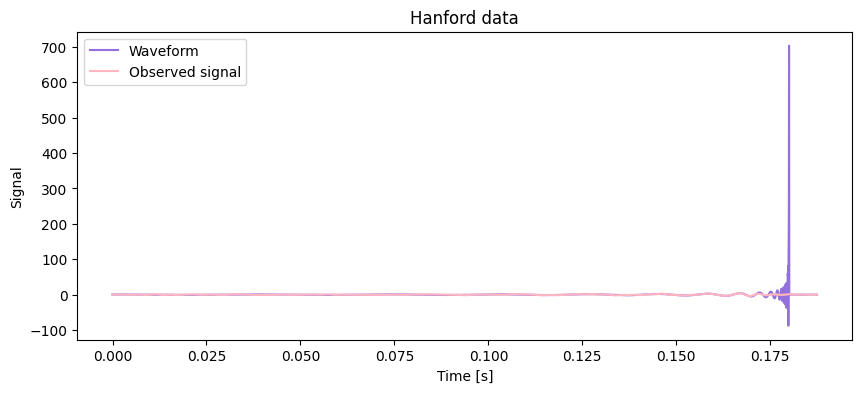

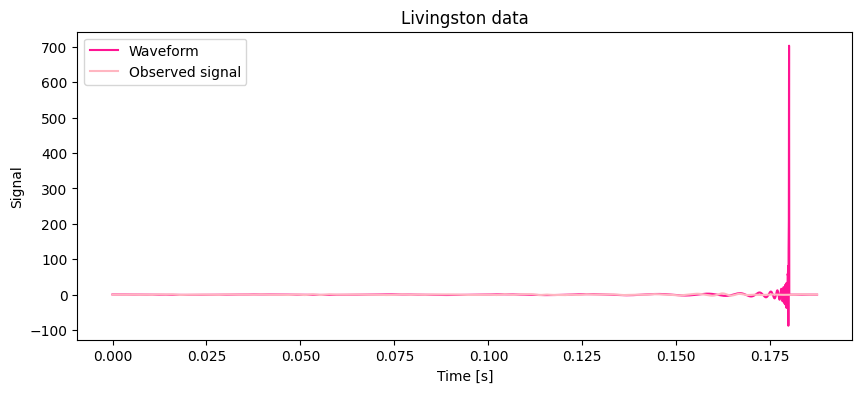

In [14]:
# Your code here for Part (b)
Nu_chirp,A0,C,n,t0=30,5,0.18,2,0.145

def f(t):
    nu=np.where((C-t)>0,151*(Nu_chirp**(-5/8))*((C-t)**(-3/8)),0)
    A=A0*((nu/100)**n)
    return np.where(t < C,A*np.cos(2*np.pi*nu*(t-t0)),0)

plt.figure(figsize=(10,4))
plt.plot(tn,f(tn),label='Waveform',color='mediumpurple')
plt.plot(tn,fn1_signal,label='Observed signal',color='lightpink')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.legend()
plt.title('Hanford data')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(tn,f(tn),label='Waveform',color='deeppink')
plt.plot(tn,fn2_signal,label='Observed signal',color='lightpink')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.legend()
plt.title('Livingston data')
plt.show()

## <font color=#46769B>Part (c): MCMC [15 points]</font>

The goal here is to use the Metropolis MCMC algorithm, following a procedure that similar to the data fitting exercises we did in class, to determine $\mathcal{M}_{\rm chirp}$. We have a model for the strain waveform, $f(t)$, which depends on several parameters denoted collectively by $\mathbf{x}$. The list of parameters $\mathbf{x}$ includes $\mathcal{M}_{\rm chirp}$, plus several other nuisance parameters that we discuss below.

The (unnormalized) PDF is

$$P(\mathbf x) = e^{- \tfrac{1}{2} \chi^2(\mathbf x)}$$

where the $\chi^2$ function is

$$\chi^2(\mathbf x) = \sum_{t_n \le t_{\rm ex}} \left(f_n^{\rm signal} - f_n^{\rm waveform}(\mathbf x)\right)^2$$ \, .

Here we provide some explanation of this formula:

- $f_n^{\rm waveform}(\mathbf x)$ is the waveform model $f(t)$ evaluated at the sample times $t_n$, for a given set of input parameters $\mathbf{x}$.

- $f_n^{\rm signal}$ is the observed waveform signal from the LIGO data that was given above.

- The sum runs over all the samples $n$ where $t_n \le t_{\rm ex}$, i.e., only sample times during the inspiral phase, which you determined in Part (a).

- We do not include a squared-uncertainty in the denominator (rather we assume that the uncertainty is equal to one).

Using the Metropolis algorithm, perform an MCMC simulation to generate a chain of $10^4$ samples for the parameters $\mathbf{x}$, given the PDF defined above. Your task is to obtain a suitable chain for the parameters $\mathbf{x}$.

To get started, you may consider the following initial sample:

$$\mathbf{x}_0 = \left( \mathcal{M}_{\rm chirp}, \, A_0, \, C , \, n, \, t_0 \right)_0 = \left(30, \, 5, \, 0.18, \, 2.0, \, 0.145 \right) \, .$$

The transition probability distribution $Q(\mathbf{x}^\prime|\mathbf{x})$ is up to you.

Your tasks are:

- Run the Metropolis algorithm, as described above.

- Plot your chains, i.e., for each parameter, make a plot showing all samples for that parameter. Add a legend to each plot labeling which parameter is shown. (You will make five separate plots.)

- Calculate and print the acceptance fraction.

- Repeat the above steps *separately* for both Hanford and Livingston datasets.

Your goal is to have a good chain that satisfies the following:

- The acceptance fraction should be around 30\%.

- Your chain plots should have no obvious burn-in phase.

- Your chain plots should appear "like noise," with step sizes that appear neither too large nor too small. That is, the chains should not be too blocky, nor should they have long excursions in the parameters.

Some hints:

- You will likely have to run your MCMC simulation multiple times to tune the best initial sample and transition PDF. You should start with a small step width for the parameters.

- It is easy to get good results if you use the covariance matrix to do multivariate sampling.

- Be sure your final code is reproducible if you __Restart and Run All__. Your notebook will be assessed on the results that are produced after the marker runs your code, not on what is there initially.

- In the Metropolis algorithm, the acceptance ratio is $\mathcal{A} = P(\mathbf{x}_{\rm new})/P(\mathbf{x}_{\rm old})$. Here we provide an alternative definition that works better for the task at hand:
$$\mathcal{A} = \exp\left(-\tfrac{1}{2} ( \chi^2(\mathbf{x}_{\rm new}) - \chi^2(\mathbf{x}_{\rm old}))\right)$$
Calculate the acceptance ratio following alternative definition, otherwise you will run into errors with numbers that are below Python's smallest allowed floats.


<ipython-input-15-54d427139332>:4: RuntimeWarning: invalid value encountered in power
  nu = np.where(condition, 151 * (Nu_chirp**(-5/8)) * ((C - t)**(-3/8)), 0)
<ipython-input-15-54d427139332>:35: RuntimeWarning: overflow encountered in exp
  A=np.exp(-0.5*(chi_sq(fn,tn,x_new,t_ex)-chi_sq(fn,tn,x0,t_ex)))


Acceptance ratio: 26.229999999999997%
Acceptance ratio: 36.52%


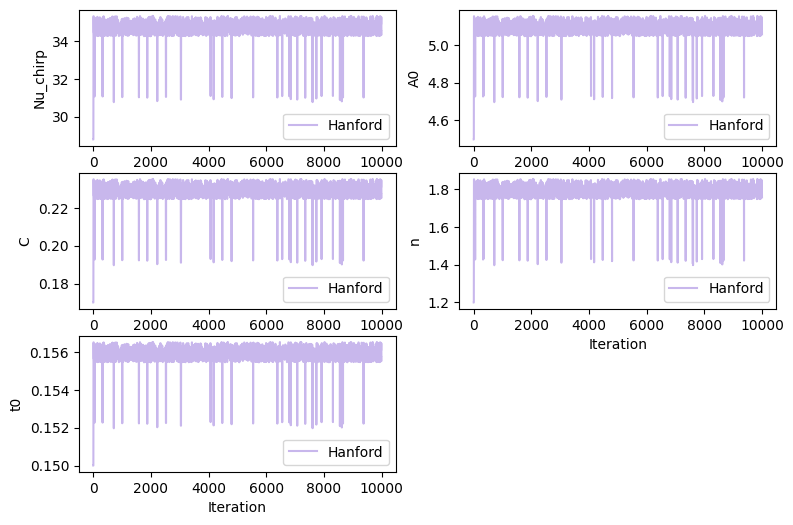

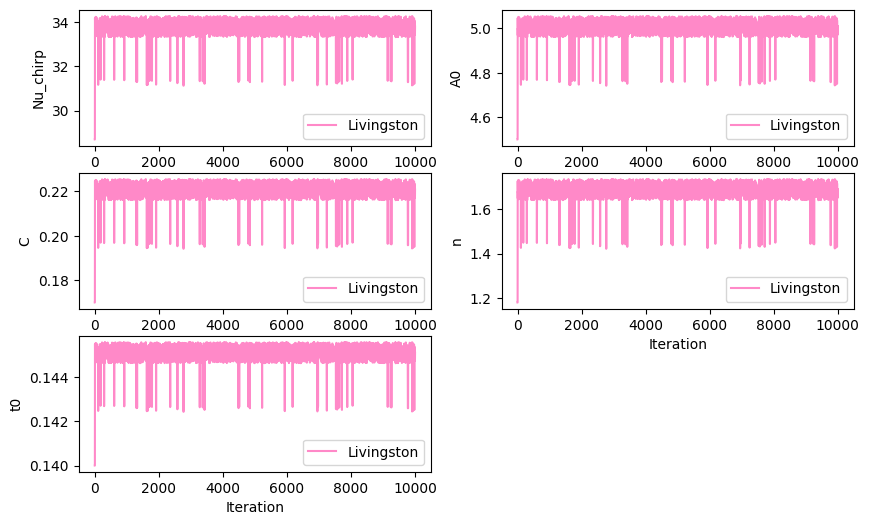

In [15]:
def f(t,x):
    Nu_chirp,A0,C,n,t0=x
    condition = t<=C
    nu = np.where(condition, 151 * (Nu_chirp**(-5/8)) * ((C - t)**(-3/8)), 0)
    A=A0*((nu/100)**n)
    return np.where(t<C,A*np.cos(2*np.pi*nu*(t-t0)),0)

def chi_sq(fn,t,x,t_ex):
  Nu_chirp,A0,C,n,t0=x
  fn_wvform=f(t,x)
  t_valid=tn<t_ex
  chi_sq=(np.sum(np.where(t_valid,(fn-fn_wvform), 0)))**2
  return chi_sq

N=10**4
num=5

def P(fn,t,x,t_ex):
  return np.exp(-0.5*chi_sq(fn,t,x,t_ex))

x_samples_H=np.array([28.8,4.5,0.17,1.2,0.15])
x_samples_L=np.array([28.7,4.5,0.17,1.18,0.14])

sigma_x=np.array([1,0.1,0.01,.1,.001])


def MCMC(N,x0,fn,tn,t_ex):
  x=[x0]
  N_a=0

  for i in range (N-1):

    x_new= x0 + sigma_x * np.random.normal(len(x0))

    A=np.exp(-0.5*(chi_sq(fn,tn,x_new,t_ex)-chi_sq(fn,tn,x0,t_ex)))

    if A > 1:
      x.append(x_new)
      N_a+=1

    else:
      r = np.random.rand()

      if r < A:
        x.append(x_new)
        N_a+=1

      else:
        x.append(x[i])

  f_a = N_a / N
  print(f'Acceptance ratio: {f_a * 100}%')

  return np.array(x)

Hanford=MCMC(N,x_samples_H,fn1_signal,tn,t_ex_1)
Livingston=MCMC(N,x_samples_L,fn2_signal,tn,t_ex_2)

param=['Nu_chirp','A0','C','n','t0']
plt.figure(figsize=(9,6))
for i in range(num):
  plt.subplot(3,2,i+1)
  plt.plot(Hanford[:,i],label='Hanford',alpha=0.5,color='mediumpurple')
  plt.xlabel('Iteration')
  plt.ylabel(param[i])
  plt.legend()
plt.show()

plt.figure(figsize=(10,6))
for i in range(num):
  plt.subplot(3,2,i+1)
  plt.plot(Livingston[:,i],label='Livingston',alpha=0.5,color='deeppink')
  plt.xlabel('Iteration')
  plt.ylabel(param[i])
  plt.legend()
plt.show()


## <font color=#46769B>Part (d): Chirp mass [10 points total]</font>

From your chains in Part (c), perform the following tasks:

- Calculate the mean and standard deviation $\mathcal{M}_{\rm chirp}$ (in $M_\odot$ units) *separately* for Hanford and Livingston datasets. This represents the central value and uncertainty your calculation of $\mathcal{M}_{\rm chirp}$.

- Plot the marginalized distribution for $\mathcal{M}_{\rm chirp}$ for both datasets on the same plot. That is, you will have two 1D histograms on the same plot. Set `alpha=0.5` and include a legend and $x$-axis label.

- Calculate a single central value and error on $\mathcal{M}_{\rm chirp}$ by combining your results from the two datasets.

Hanford dataset:
Mean Mchirp: 34.65881908890738
Standard deviation Mchirp: 0.4660701844193305

Livingston dataset:
Mean Mchirp: 33.75151079331783
Standard deviation Mchirp: 0.40152191163015327


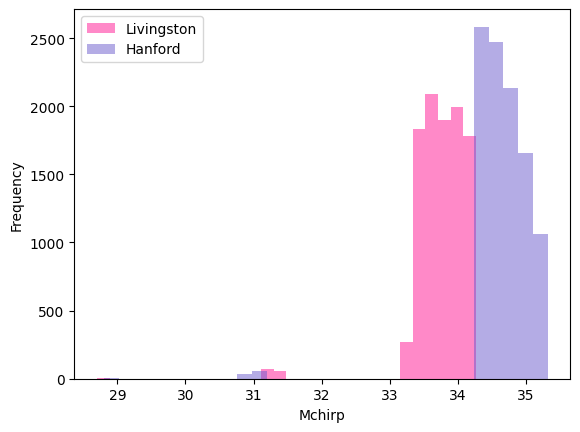

In [16]:
Mchirp_H = Hanford[:, 0]
Mchirp_L = Livingston[:, 0]

mean_Mchirp_H = np.mean(Mchirp_H)
std_Mchirp_H = np.std(Mchirp_H)

mean_Mchirp_L = np.mean(Mchirp_L)
std_Mchirp_L = np.std(Mchirp_L)

print("Hanford dataset:")
print(f"Mean Mchirp: {mean_Mchirp_H}")
print(f"Standard deviation Mchirp: {std_Mchirp_H}")

print("\nLivingston dataset:")
print(f"Mean Mchirp: {mean_Mchirp_L}")
print(f"Standard deviation Mchirp: {std_Mchirp_L}")

plt.hist(Mchirp_L, bins=30, alpha=0.5, color='deeppink', label='Livingston')
plt.hist(Mchirp_H, bins=30, alpha=0.5, color='slateblue', label='Hanford')
plt.xlabel('Mchirp')
plt.ylabel('Frequency')
plt.legend()
plt.show()